In [1]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pyclifford as pc
from numba import njit
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Lib
Copied from `MIPT.py` to allow for more flexible development.

In [14]:
def random_clifford(circ, even = True, D = 1):
    """Adds a layer of random Clifford gates to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add gates to.
        even (bool, optional): Whether to add gates starting with even or odd qudits. Defaults to True.
        D (int): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.circuit.Circuit: The circuit with gates added.
    """
    N = circ.N
    assert N % D == 0
    for i in range(int(N / D) // 2):
        if even:
            q1 = 2 * i
            q2 = 2 * i + 1
            circ.gate(*range(q1 * D, (q2 + 1) * D))
        else:
            q1 = 2 * i + 1
            q2 = (2 * i + 2) % int(N / D)
            circ.gate(*range(q1 * D, (q1 + 1) * D), *range(q2 * D, (q2 + 1) * D))
    return circ

@njit
def generate_measurement_position(N, p, D = 1):
    """Generates a random list of positions to measure.

    Args:
        N (int): The number of qubits in the circuit.
        p (float): The probability of measuring each qudit.
        D (int): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of positions to measure.
    """
    positions = []
    assert N % D == 0
    for i in range(int(N / D)):
        if np.random.rand()<p:
            for j in range(D):
                positions.append(D * i + j)
    return positions

def random_measurement(circ, p, D = 1):
    """Adds a layer of random measurements to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add measurements to.
        p (float): The probability of measuring each qudit.
        D (int): The number of qubits per qudit. Defaults to 1.

    Returns:
        pc.circuit.Circuit: The circuit with measurements added.
    """
    pos = generate_measurement_position(circ.N, p, D)
    if pos: # not empty
        circ.measure(*pos)
    return circ

def create_circuit(N, depth, p, D = 1):
    """Creates a random Clifford circuit with random measurements.
    
    Args:
        N (int): The number of qubits in the circuit.
        depth (int): The number of time steps in the circuit.
        p (float): The probability of measuring each qudit.
        D (int): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.circuit.Circuit: The random Clifford circuit.
    """
    assert N % D == 0
    if p > 0:
        circ = pc.circuit.Circuit(N)
        for _ in range(depth):
            circ = random_clifford(circ, even = True, D = D)
            circ = random_measurement(circ, p, D)
            circ = random_clifford(circ, even = False, D = D)
            circ = random_measurement(circ, p, D)
    else:
        circ = pc.circuit.Circuit(N)
        for _ in range(depth):
            circ = random_clifford(circ, even = True, D = D)
            circ = random_clifford(circ, even = False, D = D)
    return circ

def me_state(N, D = 1):
    """Creates a random maximally entangled state.

    Args:
        N (int): The number of qubits in the state.
        D (int): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.stabilizer.StabilizerState: The maximally entangled state.
    """
    state = pc.zero_state(N)
    circ = create_circuit(N, int(N / D) // 2, 0, D)
    state = circ.forward(state)
    return state

def entropy(state):
    """Calculates the bipartite entanglement entropy of the state.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the entropy of.

    Returns:
        float: The bipartite entanglement entropy.
    """
    return state.entropy([i for i in range(state.N//2)])

def evolve_entropy(state, depth, p, D = 1):
    """Computes the bipartite entanglement entropy of the state under random time evolution.

    Args:
        state (pc.stabilizer.StabilizerState): The initial state.
        depth (int): The number of time steps.
        p (float): The probability of measuring each qudit.
        D (int): The number of qubits per qudit. Defaults to 1.

    Returns:
        np.ndarray: An array of shape (depth + 1,) containing the bipartite entanglement entropies.
    """
    entropies = [entropy(state)]
    for _ in range(depth):
        circ = create_circuit(state.N, 1, p, D)
        state = circ.forward(state)
        entropies.append(entropy(state))
    return np.array(entropies)

def evolve_entropies(state, depth, p, shots = 10, D = 1, logging = True):
    """Computes an ensemble average version of evolve_entropy.

    Args:
        state (pc.stabilizer.StabilizerState): The initial state.
        depth (int): The number of time steps.
        p (float): The probability of measuring each qudit.
        shots (int, optional): The number of samples to average over. Defaults to 10.
        D (int): The number of qubits per qudit. Defaults to 1.
        logging (bool, optional): Whether to display a progress bar. Defaults to True.
    
    Returns:
        np.ndarray: An array of shape (2, depth + 1) containing the mean and std of the bipartite entanglement entropies.
    """
    if logging:
        entropies_raw = np.array([evolve_entropy(state.copy(), depth, p, D) for _ in tqdm(range(shots))])
    else:
        entropies_raw = np.array([evolve_entropy(state.copy(), depth, p, D) for _ in range(shots)])
    entropies_mean = np.mean(entropies_raw, axis = 0)
    entropies_std = np.std(entropies_raw, axis = 0, ddof = 1) / np.sqrt(shots)
    return np.array([entropies_mean, entropies_std])


# Dev

## Hist

In [4]:
n_qubits = 128
depth = 64
shots = 10
p = 0.1
D = 2

In [5]:
print("Evolving entropies for p = {}:".format(p))
S_p = []
for _ in tqdm(range(shots)):
    circ = create_circuit(n_qubits, depth, p, D = D)
    state = pc.zero_state(n_qubits)
    state = circ.forward(state)
    S_p.append(entropy(state))
S_p = np.array(S_p)

Evolving entropies for p = 0.1:


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.24s/it]


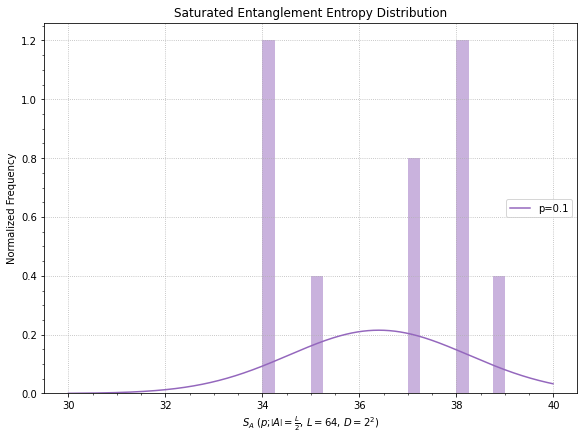

In [7]:
colors = sns.color_palette("tab10")
plt.subplots(figsize = (8, 6), layout = "constrained")
x = np.arange(30, 40, 0.01)

i = 4

entropies = S_p
plt.hist(entropies, bins=20, color=colors[i], alpha=0.5, density = True)
plt.plot(x, norm.pdf(x, *norm.fit(entropies)), color=colors[i], label="p={}".format(p))

plt.title("Saturated Entanglement Entropy Distribution")
plt.xlabel("$S_A$ ($p$;$\left|A\\right|=\\frac{{L}}{{2}}$, $L={}$, $D=2^{{{}}}$)".format(int(n_qubits / D), D))
plt.ylabel("Normalized Frequency")
plt.legend(loc = "right")
# plt.xlim(-5, 265)
# plt.ylim(0, 0.345)
plt.minorticks_on()
plt.grid(linestyle = ":")

## Time

In [15]:
n_qubits = 128
depth = 64
shots = 3
p = 0.1
D = 1

In [16]:
print("Evolving entropies for p = {}:".format(p))

state = pc.zero_state(n_qubits)
entropies_zero = evolve_entropies(state, depth, p, shots, D = D, logging = True)

state = me_state(n_qubits, D = D)
entropies_me = evolve_entropies(state, depth, p, shots, D = D, logging = True)

Evolving entropies for p = 0.1:


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


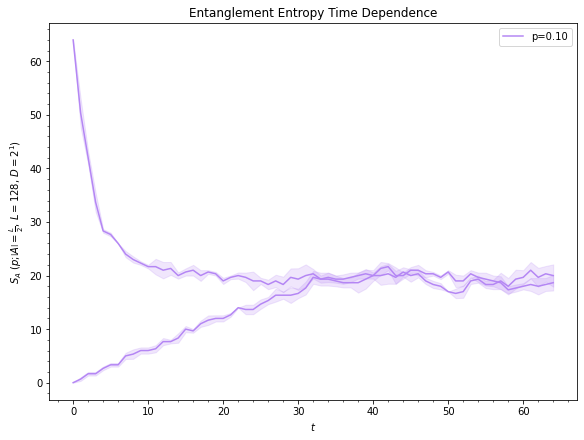

In [17]:
colors = sns.color_palette("husl", 13)
plt.subplots(figsize = (8, 6), layout = "constrained")
t = np.arange(depth + 1)

i = 10

plt.plot(t, entropies_zero[0], label="p={:.2f}".format(p), color=colors[i])
plt.fill_between(t, entropies_zero[0]-entropies_zero[1], entropies_zero[0]+entropies_zero[1], alpha=0.2, color=colors[i])
plt.plot(t, entropies_me[0], color=colors[i])
plt.fill_between(t, entropies_me[0]-entropies_me[1], entropies_me[0]+entropies_me[1], alpha=0.2, color=colors[i])

plt.title("Entanglement Entropy Time Dependence")
plt.xlabel(r"$t$")
plt.ylabel("$S_A$ ($p$;$\left|A\\right|=\\frac{{L}}{{2}}$, $L={}$, $D=2^{{{}}}$)".format(int(n_qubits / D), D))
plt.legend(loc = "upper right")
# plt.xlim(-25, 1050)
# plt.ylim(-5, 270)
plt.minorticks_on()